# Frequency sweep
Now that we can control the function generator and the oscilloscope, we are ready to set up a frequency sweep. Start by connecting to both devices and creating log string for each. Concatenate the two log strings. We will be varying the function generator frequency and oscilloscope xscale throughout the project, so set these values to the string `'VARIABLE'` in the log file. We will log them later. You may want to change the y scale of the oscilloscope depending on the transmission through your circuit, so ensure that it is a variable parameter.

In [ ]:
import siglent_sds1104xe_oscope_solution as osc 
import siglent_sdg2082x_fgen_solution as fgen
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from simple_fft import simple_fft
import os

In [ ]:
osc_inst = osc.connect('192.168.1.4')
fgen_inst = fgen.connect('192.168.1.2')

osc.initialize(osc_inst)
xscale = 'VARIABLE' 
xoffset, yoffset = 0, 0
yscale = 0.5
amplification = 1 
trigger_mode = 'AUTO'
osc.set_yscale(osc_inst, yscale)
inst_log = osc.create_log(xscale, xoffset, yscale, yoffset, amplification, trigger_mode) + '\n'

fgen.initialize(fgen_inst)
fgen.set_amplitude(fgen_inst, 1, 5)
channel = 1 
wave_type = 'SINE'
freq = 'VARIABLE' 
amp = 5 
offset = 0
inst_log += fgen.create_log(channel, wave_type, freq, amp, offset) + '\n'

Now, we need a function that will set the frequency of the function generator and set the xscale of the oscilloscope to cover two
periods per division. Put a sleep statement at the end of the function to ensure that both devices have time to be set properly.

In [ ]:
def set_freq(fgen_inst, osc_inst, freq):
    """ 
    Sets the function generator to the given frequency and sets up the 
    oscilloscope x scale to roughly ten periods per division 

    :param osc_inst: oscilloscope pyvisa resource 
    :param fgen_inst: function generator pyvisa resource
    :param freq: float, frequency in Hz 
    :param freq: float, frequency in Hz 
    """
    # set frequency of function generator
    fgen.set_frequency(fgen_inst, 1, freq)
    # set xscale of oscilloscope
    tperiod = 1 / freq 
    xscale = tperiod * 2
    osc.set_xscale(osc_inst, xscale)
    # sleep
    sleep(0.1)

We will now set up a frequency sweep. Using the following parameters, append to the log file the information about the frequency sweep and create a list of frequencies. Change the output directory to your group name. We have written code to raise an error if the files already exist, so you don't overwrite another group's data.

In [ ]:
start_freq = 1000 
end_freq = 1e6 
npoints = 100

frequencies = np.geomspace(start_freq, end_freq, npoints)
log = inst_log + "# --------- Geometric frequency sweep settings --------- #\n" 
log += f'start frequency: {start_freq} Hz\n' 
log += f'end frequency: {end_freq} Hz\n' 
log += f'number of points: {npoints}\n'


out_directory = '/home/vn-neu-daq01/SAGI2024/data/group0/sweep_00/'
log_path = out_directory + 'freqsweep.log' 
if os.path.exists(log_path):
    raise FileExistsError(f'{log_path} already exists')
with open(log_path, 'w') as f:
    f.write(log)

Now, we will create a loop to iteratively set the frequency and save data. For each frequency in `frequencies`, first set the frequency, then capture data, then save the data. Don't forget to turn on the function generator output before taking data.

In [ ]:
fgen.set_channel_state(fgen_inst, 1, 'ON')

for index, frequency in enumerate(frequencies):
    set_freq(fgen_inst, osc_inst, frequency)
    tsample, time, voltage = osc.capture_data(osc_inst) 
    np.save(out_directory + f'freqsweep_{index:03d}.npy', [time, voltage])

fgen.set_channel_state(fgen_inst, 1, 'OFF')

# Analysis
We will now import each set of data, FFT the data, extract the amplitude at the desired frequency, and plot the amplitude versus frequency. It is recommended that you scale the x-axis logarithmically and plot the y-axis in dB. We commonly use dB as our logarithmic scaling of choice for transmission through a circuit. It can be calculated from 
$$
dB = 20 \times \log\left(\frac{V_{\mathrm{out}}}{V_{\mathrm{in}}}\right)=10 \times \log\left(\frac{P_{\mathrm{out}}}{P_{\mathrm{in}}}\right)
$$
As a sanity check, plot a few of your timestreams and FFTs with an indication of the value you have selected as the peak. 

In [ ]:
index = 8

frequency = frequencies[index]
time, voltage = np.load(out_directory + f'freqsweep_{index:03d}.npy') 
tsample = time[1] - time[0]
f, y = simple_fft(tsample, voltage)
ix = np.argmin(abs(f - frequency))

fig, axs = plt.subplots(2, 1, figsize = [10, 5])
axs[1].set_xscale('log')
axs[0].plot(time, voltage) 
axs[1].plot(f, y)
axs[1].plot(f[ix], y[ix], 'xr')
print(y[ix])

In [ ]:
transmission = []
good_freqs = []
for index, frequency in enumerate(frequencies):
    time, voltage = np.load(out_directory + f'freqsweep_{index:03d}.npy') 
    if len(time):
        tsample = time[1] - time[0]
        f, y = simple_fft(tsample, voltage)
        ix = np.argmin(abs(f - frequency))
        transmission.append(y[ix])
        good_freqs.append(frequency)
good_freqs, transmission = np.array(good_freqs), np.array(transmission)

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylabel = 'Transmission (dB)', xlabel = 'Frequency (Hz)')
ax.plot(good_freqs[1:], 20 * np.log10(transmission[1:] / 2.5), 'b')

# Cleaning up frequency sweep code
You have developed the code you need to perform a frequency sweep, and now you want to wrap the code into a single function to use for the rest of the lab. Write this function and move it to 'freq_sweep.py'. Run the code from this notebook to test it. You may find that you need to add a few sleep statements to stop the code from trying to run before the previous command is finished. In practice, you will use 'get' commands or other methods to force your code to wait until each command is set on the instrument, but we are doing the quick-and-easy method of using sleep statements for now. Now that you have combined your code into a function in the .py file, are there any other functions you need to write to read in the data? Hint: where do you get your frequency list when you import the data?

In [1]:
import siglent_sds1104xe_oscope_solution as osc 
import siglent_sdg2082x_fgen_solution as fgen
from freq_sweep_solution import capture_freq_sweep

out_directory = '/home/vn-neu-daq01/SAGI2024/data/group0/sweep_00/'
out_directory = 'C:/Users/logan/Downloads/temp/'

osc_inst = osc.connect('192.168.1.4')
fgen_inst = fgen.connect('192.168.1.2')

start_freq = 1000
end_freq = 1e6 
npoints = 100
yscale = 0.5

capture_freq_sweep(out_directory, osc_inst, fgen_inst, start_freq, end_freq, npoints, yscale)

Siglent Technologies,SDS1104X-E,SDSMMFCX6R6004,8.3.6.1.37R8

Siglent Technologies,SDG2082X,SDG2XFBX7R1251,2.01.01.37R6



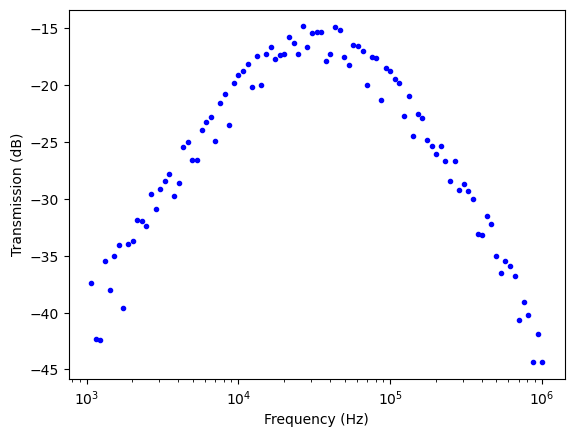

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from freq_sweep_solution import import_freq_sweep

frequencies, transmission = import_freq_sweep(out_directory)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylabel = 'Transmission (dB)', xlabel = 'Frequency (Hz)')
ax.plot(frequencies[1:], 20 * np.log10(transmission[1:] / 2.5), '.b')